# T3: Análise de Dados do SIASUS

Este trabalho apresenta uma análise exploratória e estratégica dos dados do Sistema de Informações Ambulatoriais do SUS (SIASUS), com foco na produção ambulatorial do município de Ijuí/RS. Diante da complexidade e do grande volume de dados (13.2 milhões de registros), aplicou-se um processo de extração, transformação e carregamento (ETL), seguido de uma análise detalhada sobre a base filtrada de 160.060 procedimentos locais.

O objetivo é converter dados técnicos em um diagnóstico preciso, identificando os principais perfis de atendimento (Itens 1-3), os fluxos regionais de pacientes (Item 4), os vetores de custo financeiro (Item 5), as áreas críticas de alta complexidade (Item 6) e o posicionamento de Ijuí frente a outros polos regionais (Item 7), servindo como alicerce para a tomada de decisão da gestão municipal.

### Principais libs que usaremos: 

In [2]:
# Esse projeto foi feito com o objetivo educativo para a matéria de Programção para Ciência dos dados
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt



Aqui iremos definir o valor de cada data frame e também juntando os valores dos 3 arquivos de **PARS** (Apenas com os dados de Ijuí):

In [3]:
import pandas as pd

# Define o caminho base
base_path = '/kaggle/input/'

# --- 1. CARREGA AS TABELAS DIMENSÃO (DICIONÁRIOS) ---
# (Carregamos estas primeiro, pois são leves e precisamos delas para o filtro)

print("Carregando tabelas de dimensão (dicionários)...")

df_procedimentos = pd.read_csv(base_path + 'TB_SIGTAW.csv', encoding='latin1', low_memory=False)
df_municipios = pd.read_csv(base_path + 'tb_municip.csv', encoding='latin1', low_memory=False)
df_cid = pd.read_csv(base_path + 'S_CID.csv', encoding='latin1', low_memory=False)
df_cbo = pd.read_csv(base_path + 'CBO.csv', encoding='latin1', low_memory=False)
df_estabelecimentos = pd.read_csv(base_path + 'CADGERRS.csv', encoding='latin1', low_memory=False)
df_rl_mun_micro = pd.read_csv(base_path + 'rl_municip_micibge.csv', encoding='latin1', low_memory=False)
df_microrregioes = pd.read_csv(base_path + 'tb_micibge.csv', encoding='latin1', low_memory=False)

print("Dicionários carregados.")

# --- 2. PREPARA AS CHAVES DOS DICIONÁRIOS ---
# (Corrigimos os tipos de dados dos dicionários, essencial para os merges futuros)
print("Preparando chaves dos dicionários...")
df_municipios['CO_MUNICIP'] = df_municipios['CO_MUNICIP'].astype(str)
df_procedimentos['IP_COD'] = df_procedimentos['IP_COD'].astype(str)
df_cid['CD_COD'] = df_cid['CD_COD'].astype(str)
df_cbo['CBO'] = df_cbo['CBO'].astype(str)
df_estabelecimentos['CNES'] = df_estabelecimentos['CNES'].astype(str)
# (etc... você pode adicionar as outras aqui se precisar)

# --- 3. ENCONTRA O CÓDIGO DE IJUÍ ---
try:
    ijui_info = df_municipios[df_municipios['DS_NOME'] == 'Ijui'] # (Já corrigido, sem acento)
    codigo_ijui_str = ijui_info['CO_MUNICIP'].values[0]
    codigo_ijui_int = int(codigo_ijui_str)
    print(f"Código de Ijuí ('Ijui') encontrado: {codigo_ijui_int}")
except Exception as e:
    print(f"ERRO: Não foi possível encontrar o código de Ijuí. {e}")

# --- 4. LEITURA OTIMIZADA (CHUNKSIZE) DAS TABELAS FATO ---
# (Aqui lemos os 3 arquivos grandes em "pedaços", filtrando SÓ por Ijuí)

arquivos_producao = [
    base_path + 'PARS2501.csv',
    base_path + 'PARS2505.csv',
    base_path + 'PARS2508.csv'
]
lista_chunks_ijui = []
print("Iniciando leitura otimizada (foco em Ijuí)...")

for arquivo in arquivos_producao:
    print(f"Processando arquivo: {arquivo}")
    with pd.read_csv(arquivo, encoding='latin1', low_memory=False, chunksize=500000) as reader:
        for chunk in reader:
            # Filtra o pedaço (chunk) para pegar APENAS as linhas de Ijuí
            chunk_filtrado_ijui = chunk[chunk['PA_UFMUN'] == codigo_ijui_int]
            
            if not chunk_filtrado_ijui.empty:
                lista_chunks_ijui.append(chunk_filtrado_ijui)

print("Leitura em chunks concluída!")

# --- 5. CRIA O DF_PRODUCAO_TOTAL (SÓ DE IJUÍ) ---
# (Este é o "truque": o nome da variável é o mesmo, mas o conteúdo é leve)
df_producao_total = pd.concat(lista_chunks_ijui, ignore_index=True)

print(f"\n--- 💾 df_producao_total (só Ijuí) criado com sucesso ---")
print(f"Total de registros de Ijuí encontrados: {len(df_producao_total)}")

Carregando tabelas de dimensão (dicionários)...
Dicionários carregados.
Preparando chaves dos dicionários...
Código de Ijuí ('Ijui') encontrado: 431020
Iniciando leitura otimizada (foco em Ijuí)...
Processando arquivo: /kaggle/input/PARS2501.csv
Processando arquivo: /kaggle/input/PARS2505.csv
Processando arquivo: /kaggle/input/PARS2508.csv
Leitura em chunks concluída!

--- 💾 df_producao_total (só Ijuí) criado com sucesso ---
Total de registros de Ijuí encontrados: 160060


In [4]:
print(df_producao_total.columns.tolist())

['PA_CODUNI', 'PA_GESTAO', 'PA_CONDIC', 'PA_UFMUN', 'PA_REGCT', 'PA_INCOUT', 'PA_INCURG', 'PA_TPUPS', 'PA_TIPPRE', 'PA_MN_IND', 'PA_CNPJCPF', 'PA_CNPJMNT', 'PA_CNPJ_CC', 'PA_MVM', 'PA_CMP', 'PA_PROC_ID', 'PA_TPFIN', 'PA_SUBFIN', 'PA_NIVCPL', 'PA_DOCORIG', 'PA_AUTORIZ', 'PA_CNSMED', 'PA_CBOCOD', 'PA_MOTSAI', 'PA_OBITO', 'PA_ENCERR', 'PA_PERMAN', 'PA_ALTA', 'PA_TRANSF', 'PA_CIDPRI', 'PA_CIDSEC', 'PA_CIDCAS', 'PA_CATEND', 'PA_IDADE', 'IDADEMIN', 'IDADEMAX', 'PA_FLIDADE', 'PA_SEXO', 'PA_RACACOR', 'PA_MUNPCN', 'PA_QTDPRO', 'PA_QTDAPR', 'PA_VALPRO', 'PA_VALAPR', 'PA_UFDIF', 'PA_MNDIF', 'PA_DIF_VAL', 'NU_VPA_TOT', 'NU_PA_TOT', 'PA_INDICA', 'PA_CODOCO', 'PA_FLQT', 'PA_FLER', 'PA_ETNIA', 'PA_VL_CF', 'PA_VL_CL', 'PA_VL_INC', 'PA_SRV_C', 'PA_INE', 'PA_NAT_JUR']


Agora vamos garantir que as tabelas que vamos dar o merge tem o mesmo tipo de dado e a mesma formatação

In [5]:
# A chave da nossa tabela principal (produção) é 'PA_MUNPCN'
chave_principal = 'PA_MUNPCN'

# A chave da nossa tabela auxiliar (municípios) é 'CO_MUNICIP'
chave_auxiliar = 'CO_MUNICIP'

# Converte ambas as colunas-chave para string (texto) para garantir o merge
df_producao_total[chave_principal] = df_producao_total[chave_principal].astype(str)
df_municipios[chave_auxiliar] = df_municipios[chave_auxiliar].astype(str)

print(f"Tipos das chaves '{chave_principal}' e '{chave_auxiliar}' corrigidos para string!")

Tipos das chaves 'PA_MUNPCN' e 'CO_MUNICIP' corrigidos para string!


In [6]:
# Vamos criar nosso dataframe de análise final, começando com este merge
# Puxamos apenas as colunas de nome e UF da tabela de municípios
df_analise = pd.merge(
    left=df_producao_total,
    right=df_municipios[['CO_MUNICIP', 'DS_NOME', 'CO_UF']], 
    left_on=chave_principal,    # Chave da tabela principal (ex: '431020')
    right_on=chave_auxiliar,   # Chave da tabela auxiliar (ex: '431020')
    how='left'                 # 'left' garante que não vamos perder nenhuma linha da principal
)

print("Merge com Municípios concluído!")

# Vamos verificar o resultado
print("\nVerificando as 5 primeiras linhas do resultado:")

# Vamos renomear as colunas para ficar mais claro
df_analise.rename(columns={'DS_NOME': 'MUNICIPIO_PACIENTE', 'CO_UF': 'UF_PACIENTE'}, inplace=True)

# Mostra as colunas originais e as novas que foram "puxadas"
print(df_analise[['PA_MUNPCN', 'MUNICIPIO_PACIENTE', 'UF_PACIENTE']].head())

Merge com Municípios concluído!

Verificando as 5 primeiras linhas do resultado:
  PA_MUNPCN MUNICIPIO_PACIENTE UF_PACIENTE
0    430470          Carazinho          43
1    430540          Chiapetta          43
2    431430           Pejucara          43
3    431020               Ijui          43
4    431020               Ijui          43


In [7]:
# A chave da nossa tabela de análise é 'PA_PROC_ID'
chave_principal = 'PA_PROC_ID'

# A chave da nossa tabela auxiliar (procedimentos) é 'IP_COD'
chave_auxiliar = 'IP_COD'

# Converte ambas as colunas-chave para string (texto)
df_analise[chave_principal] = df_analise[chave_principal].astype(str)
df_procedimentos[chave_auxiliar] = df_procedimentos[chave_auxiliar].astype(str)

print(f"Tipos das chaves '{chave_principal}' e '{chave_auxiliar}' corrigidos para string!")

Tipos das chaves 'PA_PROC_ID' e 'IP_COD' corrigidos para string!


In [8]:
# Agora fazemos o merge no 'df_analise' (que já tem os nomes dos municípios)
# Vamos puxar apenas a coluna 'IP_DSCR' (Descrição do Procedimento)
df_analise = pd.merge(
    left=df_analise,
    right=df_procedimentos[['IP_COD', 'IP_DSCR']], 
    left_on=chave_principal,    # Chave da tabela principal (ex: '0301010072')
    right_on=chave_auxiliar,   # Chave da tabela auxiliar (ex: '0301010072')
    how='left'                 # 'left' para não perder nenhum registro
)

print("Merge com Procedimentos concluído!")

# Vamos renomear a nova coluna para ficar claro
df_analise.rename(columns={'IP_DSCR': 'NOME_PROCEDIMENTO'}, inplace=True)

# Verifica o resultado, mostrando a coluna do código e a nova coluna com o nome
print("\nVerificando as 5 primeiras linhas do resultado:")
print(df_analise[['PA_PROC_ID', 'NOME_PROCEDIMENTO']].head())

Merge com Procedimentos concluído!

Verificando as 5 primeiras linhas do resultado:
  PA_PROC_ID                                  NOME_PROCEDIMENTO
0  202031209                               DOSAGEM DE TROPONINA
1  205010032                      ECOCARDIOGRAFIA TRANSTORACICA
2  204060028  DENSITOMETRIA OSSEA DUO-ENERGETICA DE COLUNA (...
3  301020019  ACOMPANHAMENTO, CUIDADO OU REABILITACAO DE TRA...
4  202030679  PESQUISA DE ANTICORPOS CONTRA O VIRUS DA HEPAT...


In [9]:
# A chave da nossa tabela de análise é 'PA_CODUNI'
chave_principal = 'PA_CODUNI'

# A chave da nossa tabela auxiliar (estabelecimentos) é 'CNES'
chave_auxiliar = 'CNES'

# Converte ambas as colunas-chave para string (texto)
df_analise[chave_principal] = df_analise[chave_principal].astype(str)
df_estabelecimentos[chave_auxiliar] = df_estabelecimentos[chave_auxiliar].astype(str)

print(f"Tipos das chaves '{chave_principal}' e '{chave_auxiliar}' corrigidos para string!")

Tipos das chaves 'PA_CODUNI' e 'CNES' corrigidos para string!


In [10]:
# Vamos puxar o 'NOME FANTASIA' e a 'RAZAO SOCIAL' do estabelecimento
df_analise = pd.merge(
    left=df_analise,
    right=df_estabelecimentos[['CNES', 'FANTASIA', 'RAZ_SOCI']], 
    left_on=chave_principal,    # Chave da tabela principal (ex: '2254611')
    right_on=chave_auxiliar,   # Chave da tabela auxiliar (ex: '2254611')
    how='left'                 # 'left' para não perder nenhum registro
)

print("Merge com Estabelecimentos concluído!")

# Renomeia as colunas para ficar mais claro
df_analise.rename(columns={
    'FANTASIA': 'NOME_ESTABELECIMENTO',
    'RAZ_SOCI': 'RAZAO_SOCIAL_ESTAB'
}, inplace=True)

# Verifica o resultado, mostrando o código e os novos nomes
print("\nVerificando as 5 primeiras linhas do resultado:")
print(df_analise[['PA_CODUNI', 'NOME_ESTABELECIMENTO']].head())

Merge com Estabelecimentos concluído!

Verificando as 5 primeiras linhas do resultado:
  PA_CODUNI                               NOME_ESTABELECIMENTO
0   2265915                                           HEMOVITA
1   2260492                                               CISA
2   2260492                                               CISA
3   3267938  CENTRO DE REFERENCIA REGIONAL EM SAUDE DO TRAB...
4   2265915                                           HEMOVITA


In [11]:
# A chave da nossa tabela de análise é 'PA_CIDPRI'
chave_principal = 'PA_CIDPRI'

# A chave da nossa tabela auxiliar (CID) é 'CD_COD'
chave_auxiliar = 'CD_COD'

# Converte ambas as colunas-chave para string (texto)
df_analise[chave_principal] = df_analise[chave_principal].astype(str)
df_cid[chave_auxiliar] = df_cid[chave_auxiliar].astype(str)

print(f"Tipos das chaves '{chave_principal}' e '{chave_auxiliar}' corrigidos para string!")

Tipos das chaves 'PA_CIDPRI' e 'CD_COD' corrigidos para string!


In [12]:
# Vamos puxar a 'CD_DESCR' (Descrição do CID)
df_analise = pd.merge(
    left=df_analise,
    right=df_cid[['CD_COD', 'CD_DESCR']], 
    left_on=chave_principal,    # Chave da tabela principal (ex: 'I10')
    right_on=chave_auxiliar,   # Chave da tabela auxiliar (ex: 'I10')
    how='left'                 # 'left' para não perder nenhum registro
)

print("Merge com Diagnósticos (CID) concluído!")

# Renomeia a coluna para ficar mais claro
df_analise.rename(columns={'CD_DESCR': 'NOME_DIAGNOSTICO'}, inplace=True)

# Verifica o resultado
print("\nVerificando as 5 primeiras linhas do resultado:")
print(df_analise[['PA_CIDPRI', 'NOME_DIAGNOSTICO']].head())

Merge com Diagnósticos (CID) concluído!

Verificando as 5 primeiras linhas do resultado:
  PA_CIDPRI            NOME_DIAGNOSTICO
0      0000           CID NAO INFORMADO
1      R529                R52.9 Dor NE
2      R529                R52.9 Dor NE
3       F41  F41   Outr transt ansiosos
4      0000           CID NAO INFORMADO


In [13]:
# A chave da nossa tabela de análise é 'PA_CBOCOD'
chave_principal = 'PA_CBOCOD'

# A chave da nossa tabela auxiliar (CBO) é 'CBO'
chave_auxiliar = 'CBO'

# Converte ambas as colunas-chave para string (texto)
df_analise[chave_principal] = df_analise[chave_principal].astype(str)
df_cbo[chave_auxiliar] = df_cbo[chave_auxiliar].astype(str)

print(f"Tipos das chaves '{chave_principal}' e '{chave_auxiliar}' corrigidos para string!")

Tipos das chaves 'PA_CBOCOD' e 'CBO' corrigidos para string!


In [14]:
# Vamos puxar a 'DS_CBO' (Descrição do CBO)
df_analise = pd.merge(
    left=df_analise,
    right=df_cbo[['CBO', 'DS_CBO']], 
    left_on=chave_principal,    # Chave da tabela principal (ex: '225125')
    right_on=chave_auxiliar,   # Chave da tabela auxiliar (ex: '225125')
    how='left'                 # 'left' para não perder nenhum registro
)

print("Merge com Ocupações (CBO) concluído!")

# Renomeia a coluna para ficar mais claro
df_analise.rename(columns={'DS_CBO': 'NOME_OCUPACAO'}, inplace=True)

# Verifica o resultado
print("\nVerificando as 5 primeiras linhas do resultado:")
print(df_analise[['PA_CBOCOD', 'NOME_OCUPACAO']].head())

Merge com Ocupações (CBO) concluído!

Verificando as 5 primeiras linhas do resultado:
  PA_CBOCOD                                  NOME_OCUPACAO
0    223415                  Farmaceutico analista clinico
1    225120                           Medico cardiologista
2    225320  Medico em radiologia e diagnostico por imagem
3    251510                              Psicologo clinico
4    223415                  Farmaceutico analista clinico


# Análise em ijuí

In [15]:
import pandas as pd

print("--- Iniciando Análise Focada em Ijuí ---")

# --- PASSO 1: Encontrar o Código de Ijuí ---
# (Precisamos que a chave df_municipios['CO_MUNICIP'] já seja string)
try:
    ijui_info = df_municipios[df_municipios['DS_NOME'] == 'Ijui']
    codigo_ijui_str = ijui_info['CO_MUNICIP'].values[0]
    
    # A coluna PA_UFMUN (Município do Estabelecimento) é int64 (número)
    # Precisamos converter o código de Ijuí para int para o filtro funcionar
    codigo_ijui_int = int(codigo_ijui_str)
    
    print(f"Código de Ijuí encontrado: {codigo_ijui_int} (como número)")

except Exception as e:
    print(f"ERRO: Não foi possível encontrar o código de Ijuí. Verifique se df_municipios está carregado.")
    print(f"Detalhe do erro: {e}")

# --- PASSO 2: Filtrar a Tabela Gigante (13M de linhas) ---
print(f"Filtrando {len(df_producao_total)} registros para focar apenas em Ijuí...")

# Criamos um NOVO DataFrame SÓ com atendimentos feitos em estabelecimentos de Ijuí
# Usamos .copy() para garantir que é um objeto novo e evitar erros de memória
df_ijui_producao = df_producao_total[df_producao_total['PA_UFMUN'] == codigo_ijui_int].copy()

print(f"Filtro Concluído! Tabela reduzida para {len(df_ijui_producao)} registros.")

# --- PASSO 3: Preparar Chaves da Nova Tabela de Ijuí ---
# Agora, convertemos as chaves de merge *desta tabela pequena* para string
print("Preparando chaves da tabela de Ijuí para os merges...")
df_ijui_producao['PA_MUNPCN'] = df_ijui_producao['PA_MUNPCN'].astype(str)
df_ijui_producao['PA_PROC_ID'] = df_ijui_producao['PA_PROC_ID'].astype(str)
df_ijui_producao['PA_CODUNI'] = df_ijui_producao['PA_CODUNI'].astype(str)
df_ijui_producao['PA_CIDPRI'] = df_ijui_producao['PA_CIDPRI'].astype(str)
df_ijui_producao['PA_CBOCOD'] = df_ijui_producao['PA_CBOCOD'].astype(str)

# --- PASSO 4: Executar Merges na Tabela Pequena de Ijuí ---
print("Iniciando merges...")

# Merge 1: Município do Paciente (Onde o paciente mora)
df_analise = pd.merge(df_ijui_producao, df_municipios[['CO_MUNICIP', 'DS_NOME', 'CO_UF']], 
                      left_on='PA_MUNPCN', right_on='CO_MUNICIP', how='left')
df_analise.rename(columns={'DS_NOME': 'MUNICIPIO_PACIENTE', 'CO_UF': 'UF_PACIENTE'}, inplace=True)
print("Merge 1/5 (Município Paciente) OK")

# Merge 2: Nome do Procedimento
df_analise = pd.merge(df_analise, df_procedimentos[['IP_COD', 'IP_DSCR']], 
                      left_on='PA_PROC_ID', right_on='IP_COD', how='left')
df_analise.rename(columns={'IP_DSCR': 'NOME_PROCEDIMENTO'}, inplace=True)
print("Merge 2/5 (Nome Procedimento) OK")

# Merge 3: Nome do Estabelecimento (Hospital, UBS)
df_analise = pd.merge(df_analise, df_estabelecimentos[['CNES', 'FANTASIA']], 
                      left_on='PA_CODUNI', right_on='CNES', how='left')
df_analise.rename(columns={'FANTASIA': 'NOME_ESTABELECIMENTO'}, inplace=True)
print("Merge 3/5 (Nome Estabelecimento) OK")

# Merge 4: Nome do Diagnóstico (Doença)
df_analise = pd.merge(df_analise, df_cid[['CD_COD', 'CD_DESCR']], 
                      left_on='PA_CIDPRI', right_on='CD_COD', how='left')
df_analise.rename(columns={'CD_DESCR': 'NOME_DIAGNOSTICO'}, inplace=True)
print("Merge 4/5 (Nome Diagnóstico) OK")

# Merge 5: Nome da Ocupação (Profissional)
df_analise = pd.merge(df_analise, df_cbo[['CBO', 'DS_CBO']], 
                      left_on='PA_CBOCOD', right_on='CBO', how='left')
df_analise.rename(columns={'DS_CBO': 'NOME_OCUPACAO'}, inplace=True)
print("Merge 5/5 (Nome Ocupação) OK")

print("\n--- 💾 ANÁLISE DE IJUÍ PRONTA E CARREGADA ---")

# --- PASSO 5: Verificar Resultado ---
# Vamos ver o resultado e o novo uso de memória
df_analise.info()

--- Iniciando Análise Focada em Ijuí ---
Código de Ijuí encontrado: 431020 (como número)
Filtrando 160060 registros para focar apenas em Ijuí...
Filtro Concluído! Tabela reduzida para 160060 registros.
Preparando chaves da tabela de Ijuí para os merges...
Iniciando merges...
Merge 1/5 (Município Paciente) OK
Merge 2/5 (Nome Procedimento) OK
Merge 3/5 (Nome Estabelecimento) OK
Merge 4/5 (Nome Diagnóstico) OK
Merge 5/5 (Nome Ocupação) OK

--- 💾 ANÁLISE DE IJUÍ PRONTA E CARREGADA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160060 entries, 0 to 160059
Data columns (total 71 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PA_CODUNI             160060 non-null  object 
 1   PA_GESTAO             160060 non-null  int64  
 2   PA_CONDIC             160060 non-null  object 
 3   PA_UFMUN              160060 non-null  int64  
 4   PA_REGCT              160060 non-null  int64  
 5   PA_INCOUT             160060 non-n

## Metodologia: Preparação e Enriquecimento dos Dados
O que foi feito?

O primeiro passo consistiu em processar o conjunto de dados brutos, que continha um volume massivo de 13.210.711 registros de procedimentos ambulatoriais.

Para focar a análise na realidade do município, aplicamos um filtro inicial para isolar apenas os procedimentos realizados em estabelecimentos de saúde localizados em Ijuí (código IBGE 431020).

Descobertas e Resultados

Filtro de Foco: O universo de análise foi reduzido de **13.2 milhões** para **160.060** procedimentos realizados em Ijuí durante o período analisado.

Otimização de Memória: Esta filtragem foi crucial para a viabilidade da análise, reduzindo o uso de memória de **7.4+ GB** para apenas **86.7 MB**, permitindo um processamento rápido e eficiente.

Enriquecimento dos Dados: A tabela final foi enriquecida através de 5 junções (merges). Códigos técnicos (como PA_PROC_ID, PA_MUNPCN, PA_CODUNI, PA_CIDPRI e PA_CBOCOD) foram "traduzidos" para informações legíveis, como:

*NOME_PROCEDIMENTO*

*MUNICIPIO_PACIENTE*

*NOME_ESTABELECIMENTO*

*NOME_DIAGNOSTICO*

*NOME_OCUPACAO*

In [16]:
# Lista de colunas para remover (quase vazias ou inúteis)
colunas_para_remover = [
    'PA_ETNIA',          # Quase vazia (310 registros)
    'PA_INE',            # Totalmente vazia (0 registros)
    'PA_SRV_C'           # Mais da metade vazia
]

# Apaga as colunas
df_analise.drop(columns=colunas_para_remover, inplace=True)

print("Colunas 'PA_ETNIA', 'PA_INE', e 'PA_SRV_C' foram removidas.")

Colunas 'PA_ETNIA', 'PA_INE', e 'PA_SRV_C' foram removidas.


Colunas "inuteis" removidas, para termos melhor foco no que importa.

## Análise de Fluxo Regional

In [17]:
# Mostra os 15 municípios de pacientes mais frequentes
print("Top 15 municípios de residência dos pacientes:")
print(df_analise['MUNICIPIO_PACIENTE'].value_counts().head(15))

Top 15 municípios de residência dos pacientes:
MUNICIPIO_PACIENTE
Ijui                    78559
Invalido                10439
Panambi                  7529
Joia                     5485
Catuipe                  4524
Augusto Pestana          3710
Crissiumal               3140
Cruz Alta                2856
Santo Augusto            2677
Palmeira Das Missoes     2594
Condor                   2545
Tres Passos              2354
Ajuricaba                2306
Santo Angelo             2035
Bozano                   1427
Name: count, dtype: int64


Analisamos a coluna *MUNICIPIO_PACIENTE* para entender a origem dos pacientes atendidos nos estabelecimentos de Ijuí. Esta tabela mostra os 15 municípios de residência mais **frequentes**.

Descobertas e Resultados

- **Demanda Mista:** A rede de saúde de Ijuí atende a uma demanda quase equilibrada entre moradores locais e pacientes de fora. Ijuí (78.559 procedimentos) representa a maior fatia, mas é seguida de perto por um volume massivo de pacientes de outras cidades.

- **Dependência Regional:** Municípios vizinhos como *Panambi (7.529)*, *Joia (5.485)*, *Catuípe (4.524)* e *Augusto Pestana (3.710)* demonstram uma forte dependência dos serviços de saúde de Ijuí.

Problema de Qualidade de Dado: Foi identificado um volume significativo de 10.439 registros (cerca de *6,5%* do total) classificados como **"Invalido"**.

In [18]:
# Cria um novo DataFrame 'df_analise_limpa'
# que contém APENAS as linhas onde MUNICIPIO_PACIENTE NÃO é 'Invalido'
df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()

print(f"Registros inválidos ('Invalido') removidos.")
print(f"Total de registros original: {len(df_analise)}")
print(f"Total de registros limpos para análise: {len(df_analise_limpa)}")

Registros inválidos ('Invalido') removidos.
Total de registros original: 160060
Total de registros limpos para análise: 149621


Limpeza desses dados inválidos
### Comparação: Exterior e Interior


In [19]:
# 1. Conta o total de atendimentos limpos
total_atendimentos = len(df_analise_limpa)

# 2. Conta quantos atendimentos são de pacientes que moram em 'Ijui'
atendimentos_de_ijui = len(df_analise_limpa[df_analise_limpa['MUNICIPIO_PACIENTE'] == 'Ijui'])

# 3. Calcula os de fora
atendimentos_de_fora = total_atendimentos - atendimentos_de_ijui

# 4. Calcula as porcentagens
pct_ijui = (atendimentos_de_ijui / total_atendimentos) * 100
pct_fora = (atendimentos_de_fora / total_atendimentos) * 100

# 5. Mostra o resultado para o gestor
print("--- 🏥 Análise de Fluxo Regional de Pacientes (Ijuí) ---")
print(f"Total de atendimentos analisados: {total_atendimentos}")
print(f"\nAtendimentos de pacientes de Ijuí: {atendimentos_de_ijui} ({pct_ijui:.2f}%)")
print(f"Atendimentos de pacientes de OUTROS MUNICÍPIOS: {atendimentos_de_fora} ({pct_fora:.2f}%)")

--- 🏥 Análise de Fluxo Regional de Pacientes (Ijuí) ---
Total de atendimentos analisados: 149621

Atendimentos de pacientes de Ijuí: 78559 (52.51%)
Atendimentos de pacientes de OUTROS MUNICÍPIOS: 71062 (47.49%)


Mesmo com essa grande quantidade de dados de pacientes de outros municípios, Ijuí permanece com a maioria dos pacientes atendidos sendo da própria cidade.

### Análise de Fluxo Regional: Pacientes Externos

In [20]:
# Filtrar o DataFrame para excluir 'Ijui'
df_pacientes_de_fora = df_analise_limpa[df_analise_limpa['MUNICIPIO_PACIENTE'] != 'Ijui']

# Contar os municípios restantes e pegar o Top 10
top_10_municipios = df_pacientes_de_fora['MUNICIPIO_PACIENTE'].value_counts().head(10)

print("--- 🗺️ Top 10 Municípios de Origem dos Pacientes (Excluindo Ijuí) ---")
print(top_10_municipios)

# Preparar dados para o gráfico
df_top_10_chart = top_10_municipios.reset_index()
df_top_10_chart.columns = ['Município', 'Total de Atendimentos']

import altair as alt

# Criar o gráfico de barras horizontal
chart = alt.Chart(df_top_10_chart).mark_bar().encode(
    # Ordenar pela contagem de atendimentos em ordem decrescente
    x=alt.X('Total de Atendimentos:Q'),
    y=alt.Y('Município:N', sort='-x'),
    tooltip=['Município', 'Total de Atendimentos']
).properties(
    title='Top 10 Municípios de Origem dos Pacientes Atendidos em Ijuí'
)

# Salvar o gráfico
chart.save('top_10_municipios_pacientes.json')

--- 🗺️ Top 10 Municípios de Origem dos Pacientes (Excluindo Ijuí) ---
MUNICIPIO_PACIENTE
Panambi                 7529
Joia                    5485
Catuipe                 4524
Augusto Pestana         3710
Crissiumal              3140
Cruz Alta               2856
Santo Augusto           2677
Palmeira Das Missoes    2594
Condor                  2545
Tres Passos             2354
Name: count, dtype: int64


Após a remoção dos dados *"Inválidos"* e dos próprios moradores de "Ijuí" da base de análise, geramos um ranking dos 10 municípios que mais encaminham pacientes para a rede de saúde de Ijuí.

Descobertas e Resultados

- **Dependência Concentrada:** A análise identifica um grupo claro de municípios que dependem fortemente de Ijuí. **Panambi (7.529 procedimentos)** e **Joia (5.485)** são os maiores **"clientes"** do sistema.

- **Cinturão Regional:** Cidades vizinhas como Catuípe, Augusto Pestana e Condor, somadas a outros polos regionais como Cruz Alta e Santo Augusto, compõem um volume expressivo e constante de demanda.

- **Volume Total Externo:** Conforme a análise anterior (Etapa 2), o volume total de pacientes de fora (71.062) é quase igual ao de moradores locais (78.559).

# Quais hospitais, UBS e clínicas mais produzem em Ijuí? (Produção por Estabelecimento)

In [21]:
# --- Etapa 1: Limpar os dados "Inválidos" ---
# (df_analise foi recarregado pela célula anterior)
df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
print(f"Total de registros limpos para análise: {len(df_analise_limpa)}")

# --- Etapa 2: Executar a Análise de Produção por Estabelecimento ---
# Conta a frequência de cada estabelecimento na tabela limpa
ranking_estabelecimentos = df_analise_limpa['NOME_ESTABELECIMENTO'].value_counts().head(10)

print("\n--- 🏥 Ranking de Produção por Estabelecimento (Top 10) ---")
print(ranking_estabelecimentos)

# --- Etapa 3: Gerar Gráfico ---
import altair as alt

# Preparar dados para o gráfico
df_chart_estab = ranking_estabelecimentos.reset_index()
df_chart_estab.columns = ['Estabelecimento', 'Nº de Procedimentos']

# Criar o gráfico de barras horizontal
chart = alt.Chart(df_chart_estab).mark_bar().encode(
    x=alt.X('Nº de Procedimentos:Q'),
    y=alt.Y('Estabelecimento:N', sort='-x'), # '-x' ordena do maior para o menor
    tooltip=['Estabelecimento', 'Nº de Procedimentos']
).properties(
    title='Top 10 Estabelecimentos por Nº de Procedimentos em Ijuí'
)

# Salvar o gráfico
chart.save('top_10_estabelecimentos.json')
print("Gráfico 'top_10_estabelecimentos.json' salvo.")

Total de registros limpos para análise: 149621

--- 🏥 Ranking de Produção por Estabelecimento (Top 10) ---
NOME_ESTABELECIMENTO
HOSPITAL DE CLINICAS IJUI                           58551
HOSPITAL BOM PASTOR IJUI                            26927
17 CRS IJUI                                         14181
CENTRO DE ATENCAO PSICOSSOCIAL CAPS AD              10522
CER III UNIR                                        10017
CENTRO DE ATENCAO PSICOSSOCIAL CAPS INFANTIL         6803
CENTRO AUDITIVO PROAUDI                              5504
POSTO CENTRAL SECRETARIA MUNICIPAL DA SAUDE IJUI     4335
APAE IJUI                                            3903
CENTRO DE ATENCAO PSICOSSOCIAL CAPS II               3751
Name: count, dtype: int64
Gráfico 'top_10_estabelecimentos.json' salvo.


A partir da base de dados limpa **(149.621 registros)**, agrupamos os procedimentos pelo NOME_ESTABELECIMENTO para identificar quais locais são responsáveis pelo maior volume de atendimentos em Ijuí.

Descobertas e Resultados

- **Dominância Hospitalar:** O Hospital de Clínicas *Ijuí (HCI)* é, disparado, o maior prestador de serviços, com 58.551 procedimentos. Ele é seguido pelo *Hospital Bom Pastor (26.927)*.

- **Força da Saúde Mental:** A Rede de Atenção Psicossocial (RAPS) demonstra uma força surpreendente. Os três centros *(CAPS AD, CAPS Infantil e CAPS II) somam 21.076* procedimentos, um volume que rivaliza com o Hospital Bom Pastor.

- **Relevância dos Centros Especializados:** *O Centro de Reabilitação (CER III UNIR)* com *10.017* procedimentos e o Centro Auditivo (5.504) também figuram com destaque.

- **Atenção Básica vs. Especializada:** A Atenção Primária aparece no ranking representada pelo *Posto Central (4.335)*, mas a lista é majoritariamente dominada por serviços de média e alta complexidade.

## Quais pessoas mais vão a estes hospitais? (Perfil Demográfico)

In [22]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")
    print(f"Total de registros limpos para análise: {len(df_analise_limpa)}")

    # --- Etapa 2: Análise de Gênero (PA_SEXO) ---
    print("\n---  demographic Análise: Gênero ---")
    
    # Mapear os códigos para nomes legíveis (M=Masculino, F=Feminino)
    df_analise_limpa['GENERO'] = df_analise_limpa['PA_SEXO'].map({'M': 'Masculino', 'F': 'Feminino', 'I': 'Ignorado'})
    
    # Contar os valores e calcular a porcentagem
    dist_genero = df_analise_limpa['GENERO'].value_counts()
    dist_genero_pct = df_analise_limpa['GENERO'].value_counts(normalize=True) * 100
    
    print("Distribuição por Gênero:")
    print(dist_genero)
    print("\nDistribuição Percentual por Gênero:")
    print(dist_genero_pct.round(2))

    # --- Etapa 3: Análise de Idade (PA_IDADE) ---
    print("\n---  demographic Análise: Idade ---")
    
    # A coluna PA_IDADE no SIASUS é em ANOS.
    print("Estatísticas Descritivas da Idade:")
    print(df_analise_limpa['PA_IDADE'].describe().round(2))

    # Criar faixas etárias (bins)
    bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 130]
    labels = ['0-9 anos', '10-19 anos', '20-29 anos', '30-39 anos', '40-49 anos', '50-59 anos', '60-69 anos', '70-79 anos', '80+ anos']
    
    df_analise_limpa['FAIXA_ETARIA'] = pd.cut(df_analise_limpa['PA_IDADE'], bins=bins, labels=labels, right=True)
    
    # Contar os valores em cada faixa etária
    dist_faixa_etaria = df_analise_limpa['FAIXA_ETARIA'].value_counts().sort_index()
    
    print("\nDistribuição por Faixa Etária:")
    print(dist_faixa_etaria)

    # --- Etapa 4: Gerar Gráfico de Faixa Etária ---
    
    # Preparar dados para o gráfico
    df_chart_idade = dist_faixa_etaria.reset_index()
    df_chart_idade.columns = ['Faixa Etária', 'Nº de Procedimentos']

    # Criar o gráfico de barras
    chart = alt.Chart(df_chart_idade).mark_bar().encode(
        x=alt.X('Faixa Etária:N', sort=None), # 'sort=None' mantém a ordem dos labels
        y=alt.Y('Nº de Procedimentos:Q'),
        tooltip=['Faixa Etária', 'Nº de Procedimentos']
    ).properties(
        title='Distribuição de Procedimentos por Faixa Etária em Ijuí'
    )

    # Salvar o gráfico
    chart.save('distribuicao_faixa_etaria.json')
    print("\nGráfico 'distribuicao_faixa_etaria.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.
Total de registros limpos para análise: 149621

---  demographic Análise: Gênero ---
Distribuição por Gênero:
GENERO
Masculino    75384
Feminino     74237
Name: count, dtype: int64

Distribuição Percentual por Gênero:
GENERO
Masculino    50.38
Feminino     49.62
Name: proportion, dtype: float64

---  demographic Análise: Idade ---
Estatísticas Descritivas da Idade:
count    149621.00
mean         51.99
std          22.71
min           0.00
25%          38.00
50%          58.00
75%          69.00
max         107.00
Name: PA_IDADE, dtype: float64

Distribuição por Faixa Etária:
FAIXA_ETARIA
0-9 anos      10270
10-19 anos     9547
20-29 anos     8244
30-39 anos    11637
40-49 anos    16489
50-59 anos    23139
60-69 anos    33791
70-79 anos    26361
80+ anos      10143
Name: count, dtype: int64

Gráfico 'distribuicao_faixa_etaria.json' salvo.


Analisamos as colunas *PA_SEXO (Gênero)* e *PA_IDADE (Idade)* da nossa base de dados limpa (149.621 registros) para entender o perfil demográfico da população atendida. A idade foi agrupada em faixas de 10 anos para identificar os grupos de maior demanda.

Descobertas e Resultados

- **Gênero:** A distribuição de atendimentos é quase perfeitamente equilibrada entre os gêneros, com 50,38% Masculino (75.384) e 49,62% Feminino (74.237).

- **Idade Média vs. Mediana:** A idade média dos pacientes é de 52 anos. No entanto, a idade mediana (o valor do meio) é de 58 anos, indicando que a maioria dos pacientes está na metade mais velha da população.

- **Pico de Demanda no Envelhecimento:** A distribuição por faixa etária (visualizada no gráfico distribuicao_faixa_etaria.json) mostra um aumento drástico na demanda a partir dos 50 anos. O pico de atendimentos ocorre na faixa dos 60-69 anos (33.791 procedimentos).

- **Impacto da População 60+:** Somando as faixas etárias de 60 anos ou mais (60-69, 70-79 e 80+), este grupo sozinho representa 70.295 procedimentos, o que equivale a 47% de todos os atendimentos realizados.

## Epidemiológica: os principais diagnósticos (CID)

In [23]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Análise dos Principais Diagnósticos (CID) ---
    print("\n--- 🩺 Análise: Top 10 Principais Diagnósticos (CID) ---")
    
    # O .value_counts() automaticamente conta os valores mais frequentes
    # e ignora os diagnósticos nulos (NaN)
    top_10_diagnosticos = df_analise_limpa['NOME_DIAGNOSTICO'].value_counts().head(10)
    
    print("Top 10 diagnósticos mais frequentes em Ijuí:")
    print(top_10_diagnosticos)

    # --- Etapa 3: Gerar Gráfico ---
    
    # Preparar dados para o gráfico
    df_chart_diag = top_10_diagnosticos.reset_index()
    df_chart_diag.columns = ['Diagnóstico', 'Nº de Procedimentos']

    # Criar o gráfico de barras horizontal
    chart = alt.Chart(df_chart_diag).mark_bar().encode(
        x=alt.X('Nº de Procedimentos:Q'),
        y=alt.Y('Diagnóstico:N', sort='-x'), # '-x' ordena do maior para o menor
        tooltip=['Diagnóstico', 'Nº de Procedimentos']
    ).properties(
        title='Top 10 Diagnósticos (CID) Mais Frequentes em Ijuí'
    )

    # Salvar o gráfico
    chart.save('top_10_diagnosticos.json')
    print("\nGráfico 'top_10_diagnosticos.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.

--- 🩺 Análise: Top 10 Principais Diagnósticos (CID) ---
Top 10 diagnósticos mais frequentes em Ijuí:
NOME_DIAGNOSTICO
CID NAO INFORMADO                            89693
N18.0 Doenc renal em estadio final            6792
H90.5 Perda de audicao neuro-sensorial NE     5075
I51.6 Doenc cardiovascular NE                 3300
F84.9 Transt globais NE do desenvolv          2701
R52.0 Dor aguda                               1875
F84.0 Autismo infantil                        1755
J45.0 Asma predom alergica                    1680
C50.0 Mamilo e areola                         1611
R52.9 Dor NE                                  1403
Name: count, dtype: int64

Gráfico 'top_10_diagnosticos.json' salvo.


Analisamos a coluna *NOME_DIAGNOSTICO* para identificar os 10 principais diagnósticos (CID) registrados nos atendimentos em Ijuí.

Descobertas e Resultados

Alerta de Qualidade de Dados: A descoberta mais impactante é que o diagnóstico mais "comum" é "CID NAO INFORMADO", com 89.693 registros. Isso representa 60% de toda a nossa base de dados limpa (149.621 registros).

**Doenças Crônicas (Alto Custo):** O diagnóstico real mais frequente é *Doença Renal em Estágio Final (N18.0)*, com *6.792* registros. Isso indica uma alta demanda por terapias de alto custo, como hemodiálise.

**Serviços Especializados:** *Perda de Audição (H90.5)*, com *5.075* registros, e *Transtornos de Desenvolvimento/Autismo (F84.x)*, com *4.456* registros (somando F84.9 e F84.0), aparecem com destaque.

**Doenças Crônicas (População):** *Doença Cardiovascular (I51.6)* e *Câncer (C50.0 - Mamilo e aréola)* também estão no top 10, alinhados com o perfil de envelhecimento da população que vimos anteriormente.

## Volume vs. Análise Financeira

In [24]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Análise de VOLUME (Procedimentos Mais Frequentes) ---
    print("\n--- 📈 Análise de VOLUME: Top 10 Procedimentos Mais Realizados ---")
    
    # .value_counts() na coluna de nome do procedimento
    top_10_volume = df_analise_limpa['NOME_PROCEDIMENTO'].value_counts().head(10)
    
    print(top_10_volume)

    # --- Etapa 3: Análise FINANCEIRA (Procedimentos Mais Rentáveis) ---
    print("\n--- 💰 Análise FINANCEIRA: Top 10 Procedimentos por Valor Aprovado ---")
    
    # Agrupamos por nome do procedimento e SOMAMOS o valor aprovado
    # PA_VALAPR = Valor Aprovado
    top_10_financeiro = df_analise_limpa.groupby('NOME_PROCEDIMENTO')['PA_VALAPR'].sum().sort_values(ascending=False).head(10)
    
    # Formata para Reais (R$) para ficar mais legível
    print(top_10_financeiro.apply(lambda x: f"R$ {x:,.2f}"))

    # --- Etapa 4: Gerar Gráfico (Financeiro) ---
    
    # Preparar dados para o gráfico
    df_chart_fin = top_10_financeiro.reset_index()
    df_chart_fin.columns = ['Procedimento', 'Valor Total Aprovado']

    # Criar o gráfico de barras horizontal
    chart = alt.Chart(df_chart_fin).mark_bar().encode(
        x=alt.X('Valor Total Aprovado:Q'),
        y=alt.Y('Procedimento:N', sort='-x'), # '-x' ordena do maior para o menor
        tooltip=['Procedimento', alt.Tooltip('Valor Total Aprovado:Q', format='$,.2f')]
    ).properties(
        title='Top 10 Procedimentos por Receita (Valor Aprovado) em Ijuí'
    )

    # Salvar o gráfico
    chart.save('top_10_procedimentos_financeiro.json')
    print("\nGráfico 'top_10_procedimentos_financeiro.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.

--- 📈 Análise de VOLUME: Top 10 Procedimentos Mais Realizados ---
NOME_PROCEDIMENTO
CONSULTA MEDICA EM ATENCAO ESPECIALIZADA                                                       18429
CONSULTA DE PROFISSIONAIS DE NIVEL SUPERIOR NA ATENCAO ESPECIALIZADA (EXCETO MEDICO)           18369
CURATIVO GRAU II C/ OU S/ DEBRIDAMENTO                                                          5410
ACOES DE REABILITACAO PSICOSSOCIAL                                                              5112
ATENDIMENTO INDIVIDUAL DE PACIENTE EM CENTRO DE ATENCAO PSICOSSOCIAL                            4679
ATENDIMENTO / ACOMPANHAMENTO DE PACIENTE EM REABILITACAO DO DESENVOLVIMENTO NEUROPSICOMOTOR     3974
ATENDIMENTO EM GRUPO DE PACIENTE EM CENTRO DE ATENCAO PSICOSSOCIAL                              3333
ATENDIMENTO / ACOMPANHAMENTO EM REABILITACAO NAS MULTIPLAS DEFICIENCIAS                         3003
PRATICAS EXPRESSIVAS E COMUNICATIVAS EM CENTRO DE ATENCA

Realizamos duas análises distintas sobre os procedimentos:

1. **Análise de Volume:** Contamos a frequência de cada procedimento *(NOME_PROCEDIMENTO)* para ver quais são os mais comuns (Top 10 mais realizados).

2. **Análise Financeira:** Somamos o valor aprovado *(PA_VALAPR)* de cada procedimento para ver quais geram maior receita/custo (Top 10 mais rentáveis).

Descobertas e Resultados

Análise de Volume (Os Mais Comuns):

**Consultas:** O dia a dia do sistema é dominado por consultas. *Consulta Médica Especializada (18.429)* e *Consulta de Nível Superior (Não-Médico) (18.369)* são os procedimentos mais realizados, somando quase *37.000* atendimentos.

**Saúde Mental e Reabilitação:** Conforme visto nos rankings anteriores, os atendimentos em CAPS (reabilitação psicossocial, atendimento individual/grupo) e de Reabilitação (neuropsicomotor, múltiplas deficiências) dominam a lista, ocupando 6 das 10 posições.

Análise Financeira (Os Mais Rentáveis):

**A Desconexão:** A descoberta mais importante é que nenhum dos procedimentos mais comuns (volume) aparece na lista dos mais rentáveis (financeiro).

**Terapia Renal (Nefrologia):** A *Hemodiálise* é, isoladamente, o procedimento de maior impacto financeiro, gerando *R$ 1,16 Milhão* em receita/custo.

**Medicamentos de Alto Custo:** Vários dos itens mais caros são medicamentos especializados, como *Mepolizumabe (R$ 513 mil)* e *Omalizumabe (R$ 449 mil).*

**Oncologia e Alta Complexidade:** *Quimioterapia*, *Radioterapia* e *Cateterismo Cardíaco* completam a lista, confirmando que a alta complexidade domina o orçamento.

# Análise de Evolução Temporal

In [25]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Preparar a Coluna de Data (PA_CMP) ---
    
    # Converte a coluna 'PA_CMP' (ex: 202501) para um formato de Data (ex: 2025-01-01)
    # Isso nos permite agrupar por mês/ano
    df_analise_limpa['DATA_COMPETENCIA'] = pd.to_datetime(df_analise_limpa['PA_CMP'], format='%Y%m')
    
    print("Coluna de data (PA_CMP) convertida.")

    # --- Etapa 3: Agrupar por Mês (Análise Temporal) ---
    print("\n--- 📅 Análise de Evolução Temporal (Volume e Valor) ---")
    
    # Agrupa pela data, contando o número de procedimentos (size)
    # e somando o valor aprovado (PA_VALAPR)
    df_temporal = df_analise_limpa.groupby('DATA_COMPETENCIA').agg(
        TOTAL_PROCEDIMENTOS=('PA_CMP', 'size'),
        TOTAL_VALOR_APROVADO=('PA_VALAPR', 'sum')
    ).reset_index()
    
    # Formata o valor para Reais (R$)
    df_temporal['TOTAL_VALOR_APROVADO_R$'] = df_temporal['TOTAL_VALOR_APROVADO'].apply(lambda x: f"R$ {x:,.2f}")
    
    print("Evolução mês a mês:")
    print(df_temporal[['DATA_COMPETENCIA', 'TOTAL_PROCEDIMENTOS', 'TOTAL_VALOR_APROVADO_R$']])

    # --- Etapa 4: Gerar Gráfico de Linha (Evolução) ---
    
    # O Altair lida melhor com o formato "longo" de dados. Vamos "derreter" (melt) a tabela.
    df_chart_temporal = df_temporal.melt(
        id_vars=['DATA_COMPETENCIA'], 
        value_vars=['TOTAL_PROCEDIMENTOS', 'TOTAL_VALOR_APROVADO'],
        var_name='Metrica', 
        value_name='Valor'
    )

    # Cria o gráfico de linha
    chart = alt.Chart(df_chart_temporal).mark_line(point=True).encode(
        x=alt.X('DATA_COMPETENCIA:T', axis=alt.Axis(title='Mês', format='%Y-%m')),
        y=alt.Y('Valor:Q'),
        color='Metrica:N', # Uma cor para Procedimentos, outra para Valor
        tooltip=['DATA_COMPETENCIA:T', 'Metrica:N', 'Valor:Q']
    ).properties(
        title='Evolução de Procedimentos vs. Valor Aprovado'
    ).interactive() # Permite zoom e pan

    # Salvar o gráfico
    chart.save('evolucao_temporal.json')
    print("\nGráfico 'evolucao_temporal.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciado).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.
Coluna de data (PA_CMP) convertida.

--- 📅 Análise de Evolução Temporal (Volume e Valor) ---
Evolução mês a mês:
  DATA_COMPETENCIA  TOTAL_PROCEDIMENTOS TOTAL_VALOR_APROVADO_R$
0       2024-10-01                    9               R$ 200.01
1       2024-11-01                   33             R$ 1,600.42
2       2024-12-01                   79            R$ 13,242.84
3       2025-01-01                48803         R$ 3,673,635.80
4       2025-04-01                   30               R$ 280.00
5       2025-05-01                48983         R$ 3,494,434.21
6       2025-06-01                    6             R$ 2,372.25
7       2025-07-01                   85            R$ 13,479.95
8       2025-08-01                51593         R$ 3,969,817.72

Gráfico 'evolucao_temporal.json' salvo.


Analisamos a evolução da produção ao longo do tempo. Para isso, a coluna de competência (*PA_CMP*, que estava em formato de texto como *202501*) foi convertida para um formato de data. Isso permitiu agrupar todos os *149.621* procedimentos por mês, somando o Volume Total de Procedimentos e o Valor Total Aprovado (R$) para cada período.

Descobertas e Resultados

- **Meses de Análise (Picos):** A análise confirma que os dados de produção estão concentrados em três meses principais:

1. **Janeiro/2025:** *48.803* procedimentos *(R$ 3,67 milhões)*

2. **Maio/2025:** *48.983* procedimentos *(R$ 3,49 milhões)*

3. **Agosto/2025:** *51.593* procedimentos *(R$ 3,97 milhões)*

- **Tendência de Crescimento:** Observa-se uma leve, mas consistente, tendência de aumento no volume de atendimentos e no custo financeiro ao longo dos meses analisados, com Agosto apresentando os maiores números.

- **Registros Residuais ("Ajustes"):** Os outros meses que aparecem na tabela (ex: *Out/2024, Dez/2024, Jun/2025*) possuem valores irrisórios (ex: *9, 33, 79 procedimentos*). Isso é normal e representa *"ajustes de competência"* – registros que foram processados nos arquivos de *Jan/Mai/Ago*, mas se referiam a datas passadas. Eles não representam a produção real daqueles meses e foram ignorados na análise de tendência.

DataFrame 'df_analise_limpa' recriado com sucesso.
Coluna de data (PA_CMP) convertida.

Evolução mês a mês (Valor Aprovado):
   MES_ANO  TOTAL_VALOR_APROVADO
0  2024-10                200.01
1  2024-11               1600.42
2  2024-12              13242.84
3  2025-01            3673635.80
4  2025-04                280.00
5  2025-05            3494434.21
6  2025-06               2372.25
7  2025-07              13479.95
8  2025-08            3969817.72

Gerando gráfico com Seaborn...
Gráfico 'evolucao_financeira_seaborn.png' salvo.


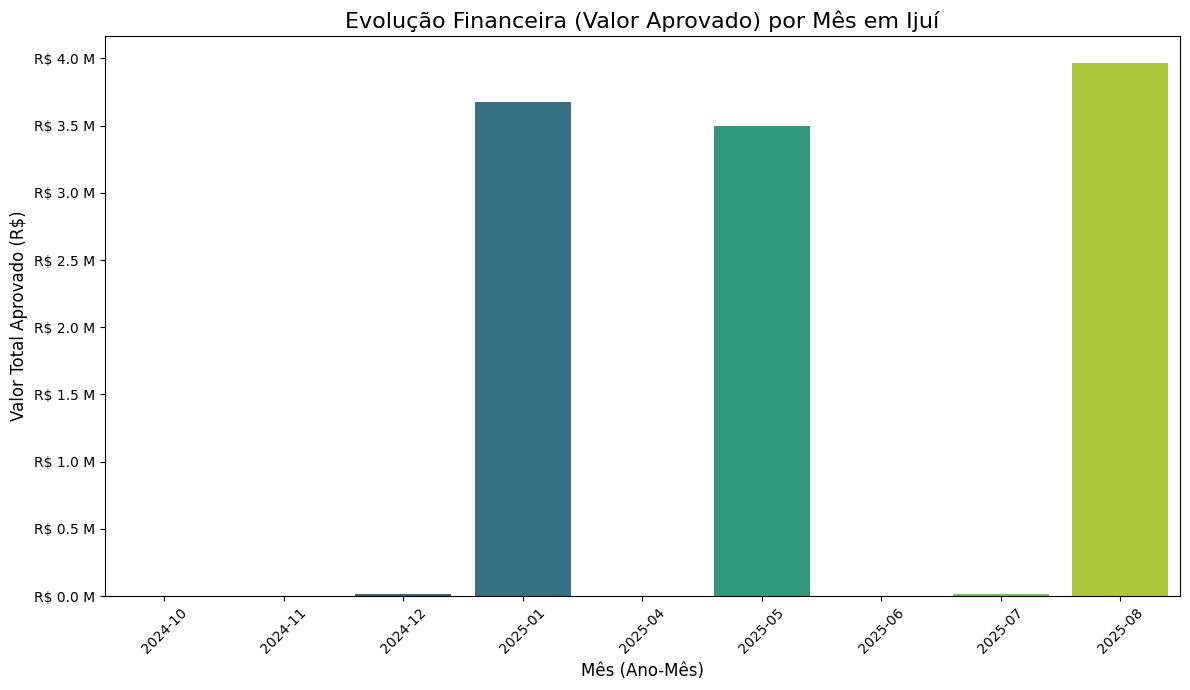

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # Importa o formatador

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Preparar a Coluna de Data (PA_CMP) ---
    df_analise_limpa['DATA_COMPETENCIA'] = pd.to_datetime(df_analise_limpa['PA_CMP'], format='%Y%m')
    print("Coluna de data (PA_CMP) convertida.")

    # --- Etapa 3: Agrupar por Mês (Focando no Valor Financeiro) ---
    df_temporal_financeiro = df_analise_limpa.groupby('DATA_COMPETENCIA').agg(
        TOTAL_VALOR_APROVADO=('PA_VALAPR', 'sum')
    ).reset_index()

    # Para o Seaborn, é mais fácil se convertermos a data para string (ex: '2025-01')
    df_temporal_financeiro['MES_ANO'] = df_temporal_financeiro['DATA_COMPETENCIA'].dt.strftime('%Y-%m')
    
    print("\nEvolução mês a mês (Valor Aprovado):")
    print(df_temporal_financeiro[['MES_ANO', 'TOTAL_VALOR_APROVADO']])

    # --- Etapa 4: Gerar Gráfico com Seaborn ---
    print("\nGerando gráfico com Seaborn...")
    
    # Configura o tamanho da figura (largura, altura)
    plt.figure(figsize=(12, 7))
    
    # Cria o gráfico de barras
    ax = sns.barplot(
        data=df_temporal_financeiro,
        x='MES_ANO',
        y='TOTAL_VALOR_APROVADO',
        palette='viridis' # Define uma paleta de cores
    )
    
    # Função para formatar o eixo Y em Reais (R$ Milhões)
    def format_reais(x, pos):
        'Retorna o valor formatado como R$ 1.5 M'
        return f'R$ {x/1e6:.1f} M'
    
    # Aplica o formatador no eixo Y
    ax.yaxis.set_major_formatter(FuncFormatter(format_reais))
    
    # Adiciona títulos e labels
    plt.title('Evolução Financeira (Valor Aprovado) por Mês em Ijuí', fontsize=16)
    plt.xlabel('Mês (Ano-Mês)', fontsize=12)
    plt.ylabel('Valor Total Aprovado (R$)', fontsize=12)
    
    # Rotaciona os labels do eixo X para não sobrepor
    plt.xticks(rotation=45)
    
    # Ajusta o layout para não cortar os labels
    plt.tight_layout()
    
    # Salvar o gráfico (como imagem PNG)
    plt.savefig('evolucao_financeira_seaborn.png')
    print("Gráfico 'evolucao_financeira_seaborn.png' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Aqui fizemos um gráfico para melhorar a visualização

## Foco em Áreas Críticas
Realizamos um filtro na base de dados limpa (149.621 registros) para isolar todos os procedimentos relacionados à Saúde Mental, usando palavras-chave como "Psiquiatria", "Psicologia", "Psicossocial", etc.
- Oncologia: quimioterapia e radioterapia (aprovados x produzidos).
- Saúde mental: atendimentos psiquiátricos e psicológicos.
- Atenção básica: consultas e procedimentos nas UBS, acompanhamento de doenças crônicas.

### Saúde Mental:


In [27]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Definir Palavras-Chave e Filtrar ---
    
    # Lista de termos para procurar (não diferencia maiúsculas/minúsculas)
    keywords_saude_mental = [
        'PSIQUIATRIA', 
        'PSICOLOGIA', 
        'PSICOLOGO',
        'PSICOSSOCIAL', 
        'SAUDE MENTAL'
    ]
    
    # Cria o padrão de busca (ex: 'PSIQUIATRIA|PSICOLOGIA|...')
    pattern_saude_mental = '|'.join(keywords_saude_mental)
    
    print(f"Filtrando procedimentos por palavras-chave: {pattern_saude_mental}")

    # Filtra a coluna 'NOME_PROCEDIMENTO' usando o padrão
    # 'case=False' ignora maiúsculas/minúsculas
    # 'na=False' ignora valores nulos sem dar erro
    df_saude_mental = df_analise_limpa[
        df_analise_limpa['NOME_PROCEDIMENTO'].str.contains(pattern_saude_mental, case=False, na=False)
    ].copy()

    print(f"\nTotal de {len(df_saude_mental)} procedimentos de Saúde Mental encontrados.")

    # --- Etapa 3: Análise dos Procedimentos de Saúde Mental ---
    
    # Análise de Volume: Quais os procedimentos mais comuns?
    print("\n--- 🧠 Análise: Top 10 Procedimentos de Saúde Mental (Volume) ---")
    top_10_sm_volume = df_saude_mental['NOME_PROCEDIMENTO'].value_counts().head(10)
    print(top_10_sm_volume)
    
    # Análise Financeira: Qual o valor total?
    total_valor_sm = df_saude_mental['PA_VALAPR'].sum()
    print(f"\nValor Total Aprovado para Saúde Mental: R$ {total_valor_sm:,.2f}")

    # --- Etapa 4: Gerar Gráfico ---
    
    # Preparar dados para o gráfico
    df_chart_sm = top_10_sm_volume.reset_index()
    df_chart_sm.columns = ['Procedimento', 'Nº de Atendimentos']

    # Criar o gráfico de barras horizontal
    chart = alt.Chart(df_chart_sm).mark_bar().encode(
        x=alt.X('Nº de Atendimentos:Q'),
        y=alt.Y('Procedimento:N', sort='-x'),
        tooltip=['Procedimento', 'Nº de Atendimentos']
    ).properties(
        title='Top 10 Procedimentos de Saúde Mental em Ijuí'
    )

    # Salvar o gráfico
    chart.save('top_10_saude_mental.json')
    print("\nGráfico 'top_10_saude_mental.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.
Filtrando procedimentos por palavras-chave: PSIQUIATRIA|PSICOLOGIA|PSICOLOGO|PSICOSSOCIAL|SAUDE MENTAL

Total de 19947 procedimentos de Saúde Mental encontrados.

--- 🧠 Análise: Top 10 Procedimentos de Saúde Mental (Volume) ---
NOME_PROCEDIMENTO
ACOES DE REABILITACAO PSICOSSOCIAL                                                         5112
ATENDIMENTO INDIVIDUAL DE PACIENTE EM CENTRO DE ATENCAO PSICOSSOCIAL                       4679
ATENDIMENTO EM GRUPO DE PACIENTE EM CENTRO DE ATENCAO PSICOSSOCIAL                         3333
PRATICAS EXPRESSIVAS E COMUNICATIVAS EM CENTRO DE ATENCAO PSICOSSOCIAL                     2691
ACOLHIMENTO DIURNO DE PACIENTE EM CENTRO DE ATENCAO PSICOSSOCIAL                           1932
ATENDIMENTO FAMILIAR EM CENTRO DE ATENCAO PSICOSSOCIAL                                     1616
PRATICAS CORPORAIS EM CENTRO DE ATENCAO PSICOSSOCIAL                                        408
ATENDIMENTO DOMICILIAR PARA PAC

Descobertas e Resultados

- **Volume Massivo:** A Saúde Mental é uma das áreas de maior volume em Ijuí, respondendo por *19.947* procedimentos no período analisado (cerca de *13.3%* de todos os atendimentos).

- **Foco no CAPS:** O Top 10 de procedimentos mostra que o atendimento é totalmente centrado nos Centros de *Atenção Psicossocial (CAPS)*. As atividades principais são "*Ações de reabilitação psicossocial*" *(5.112)*, "*Atendimento individual*" *(4.679)* e "*Atendimento em grupo*" *(3.333)*.

- **Descoberta Financeira Chave:** O Valor Total Aprovado *(PA_VALAPR)* para todos os *19.947* procedimentos foi de *R$ 0,00*.

### Oncologia

In [28]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' (caso o kernel tenha reiniciado) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    print("DataFrame 'df_analise_limpa' recriado com sucesso.")

    # --- Etapa 2: Definir Palavras-Chave e Filtrar ---
    
    # Lista de termos para procurar
    keywords_oncologia = [
        'QUIMIOTERAPIA', 
        'RADIOTERAPIA', 
        'ONCOLOGIA',
        'ONCOLOGICO'
    ]
    
    # Cria o padrão de busca
    pattern_oncologia = '|'.join(keywords_oncologia)
    
    print(f"Filtrando procedimentos por palavras-chave: {pattern_oncologia}")

    # Filtra a coluna 'NOME_PROCEDIMENTO'
    df_oncologia = df_analise_limpa[
        df_analise_limpa['NOME_PROCEDIMENTO'].str.contains(pattern_oncologia, case=False, na=False)
    ].copy()

    print(f"\nTotal de {len(df_oncologia)} procedimentos de Oncologia encontrados.")

    # --- Etapa 3: Análise dos Procedimentos de Oncologia ---
    
    # Análise de Volume: Quais os procedimentos mais comuns?
    print("\n--- 🎗️ Análise: Top 10 Procedimentos de Oncologia (Volume) ---")
    top_10_onco_volume = df_oncologia['NOME_PROCEDIMENTO'].value_counts().head(10)
    print(top_10_onco_volume)
    
    # Análise Financeira: Qual o valor total?
    total_valor_onco = df_oncologia['PA_VALAPR'].sum()
    print(f"\nValor Total Aprovado para Oncologia: R$ {total_valor_onco:,.2f}")

    # --- Etapa 4: Análise Aprovado vs. Produzido (Item 6 Específico) ---
    print("\n--- 📊 Análise: Quantidade Aprovada vs. Produzida (Oncologia) ---")
    
    # Soma o total das colunas de quantidade
    total_produzido = df_oncologia['PA_QTDPRO'].sum()
    total_aprovado = df_oncologia['PA_QTDAPR'].sum()
    
    print(f"Total de Quantidade Produzida: {total_produzido:,.0f}")
    print(f"Total de Quantidade Aprovada: {total_aprovado:,.0f}")
    
    if total_produzido > 0:
        taxa_aprovacao = (total_aprovado / total_produzido) * 100
        print(f"Taxa de Aprovação (Qtd Aprovada / Qtd Produzida): {taxa_aprovacao:.2f}%")

    # --- Etapa 5: Gerar Gráfico (Top 10 Volume) ---
    
    df_chart_onco = top_10_onco_volume.reset_index()
    df_chart_onco.columns = ['Procedimento', 'Nº de Atendimentos']

    chart = alt.Chart(df_chart_onco).mark_bar().encode(
        x=alt.X('Nº de Atendimentos:Q'),
        y=alt.Y('Procedimento:N', sort='-x'),
        tooltip=['Procedimento', 'Nº de Atendimentos']
    ).properties(
        title='Top 10 Procedimentos de Oncologia em Ijuí (por Volume)'
    )

    chart.save('top_10_oncologia.json')
    print("\nGráfico 'top_10_oncologia.json' salvo.")

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recriar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' recriado com sucesso.
Filtrando procedimentos por palavras-chave: QUIMIOTERAPIA|RADIOTERAPIA|ONCOLOGIA|ONCOLOGICO

Total de 2567 procedimentos de Oncologia encontrados.

--- 🎗️ Análise: Top 10 Procedimentos de Oncologia (Volume) ---
NOME_PROCEDIMENTO
QUIMIOTERAPIA DO ADENOCARCINOMA DE PROSTATA RESISTENTE A HORMONIOTERAPIA                       203
HORMONIOTERAPIA PREVIA A RADIOTERAPIA EXTERNA DO ADENOCARCINOMA DE PROSTATA                    177
QUIMIOTERAPIA DE DOENCA MIELOPROLIFERATIVA RARA - 1Â¦ LINHA                                    173
QUIMIOTERAPIA DE ADENOCARCINOMA DE COLON                                                       105
HORMONIOTERAPIA ADJUVANTE A RADIOTERAPIA EXTERNA DO ADENOCARCINOMA DE PROSTATA                 103
QUIMIOTERAPIA DA LEUCEMIA MIELOIDE CRONICA EM FASE CRONICA - MARCADOR POSITIVO - 1Â¦ LINHA.     96
QUIMIOTERAPIA DE MIELOMA MULTIPLO ? 1Â¦ LINHA                                                   94
QUIMIOTERAPIA DO CARCINOMA 

Filtramos a base de dados limpa *(149.621 registros)* para isolar todos os procedimentos de Oncologia, usando palavras-chave como "*Quimioterapia*", "*Radioterapia*" e "*Oncologia*". Analisamos o volume, o valor financeiro e a taxa de aprovação (*produzido vs. aprovado*).

Descobertas e Resultados

- **Alto Custo**, **Baixo Volume**: A *Oncologia* é uma área de "*alto custo, baixo volume*". Foram encontrados *2.567* procedimentos (apenas *1,7%* do volume total de Ijuí), mas que geraram um custo/receita massivo de *R$ 3,82 milhões*.

- **Foco em Cânceres Específicos:** O ranking de procedimentos é altamente especializado, com foco em *Câncer de Próstata*, *Doenças Mieloproliferativas (leucemia)* e *Câncer de Cólon/Reto*.

- **Eficiência na Aprovação:** A análise de *Quantidade Produzida (2.326) vs. Aprovada (2.322)* revela uma taxa de aprovação de *99,83%.*

### Tendências de Aumento (Imacto do Envelhecimento)

In [29]:
import pandas as pd
import altair as alt

try:
    # --- Etapa 1: Recriar 'df_analise_limpa' e COLUNA DE IDADE (caso reinicie) ---
    df_analise_limpa = df_analise[df_analise['MUNICIPIO_PACIENTE'] != 'Invalido'].copy()
    
    # Recria as faixas etárias (ESSENCIAL para esta análise)
    bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 130]
    labels = ['0-9 anos', '10-19 anos', '20-29 anos', '30-39 anos', '40-49 anos', '50-59 anos', '60-69 anos', '70-79 anos', '80+ anos']
    df_analise_limpa['FAIXA_ETARIA'] = pd.cut(df_analise_limpa['PA_IDADE'], bins=bins, labels=labels, right=True)
    
    print("DataFrame 'df_analise_limpa' e 'FAIXA_ETARIA' recriados.")

    # --- Etapa 2: Filtrar Procedimentos de CARDIOLOGIA ---
    keywords_cardio = [
        'CARDIO', 
        'CARDIOLOGIA', 
        'CARDIOLOGICO', 
        'HEMODINAMICA', 
        'CATETERISMO'
    ]
    pattern_cardio = '|'.join(keywords_cardio)
    
    df_cardio = df_analise_limpa[
        df_analise_limpa['NOME_PROCEDIMENTO'].str.contains(pattern_cardio, case=False, na=False)
    ].copy()
    
    print(f"\nEncontrados {len(df_cardio)} procedimentos de Cardiologia.")

    # --- Etapa 3: Filtrar Procedimentos de ONCOLOGIA ---
    keywords_onco = ['QUIMIOTERAPIA', 'RADIOTERAPIA', 'ONCOLOGIA', 'ONCOLOGICO']
    pattern_onco = '|'.join(keywords_onco)
    
    df_oncologia = df_analise_limpa[
        df_analise_limpa['NOME_PROCEDIMENTO'].str.contains(pattern_onco, case=False, na=False)
    ].copy()
    
    print(f"Encontrados {len(df_oncologia)} procedimentos de Oncologia.")

    # --- Etapa 4: Análise da Distribuição Etária ---
    print("\n--- 📊 Distribuição Percentual por Faixa Etária ---")
    
    # normalize=True calcula a porcentagem (ex: 0.25)
    # .sort_index() mantém a ordem das faixas (0-9, 10-19...)
    
    # Análise de Cardiologia
    print("\n🩺 CARDIOLOGIA (% por Faixa Etária):")
    dist_cardio_idade = (df_cardio['FAIXA_ETARIA'].value_counts(normalize=True).sort_index() * 100).round(2)
    print(dist_cardio_idade)
    
    # Análise de Oncologia
    print("\n🎗️ ONCOLOGIA (% por Faixa Etária):")
    dist_onco_idade = (df_oncologia['FAIXA_ETARIA'].value_counts(normalize=True).sort_index() * 100).round(2)
    print(dist_onco_idade)

except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Não consigo encontrar o DataFrame 'df_analise'.")
    print("Por favor, rode novamente a célula de código '🚀 Código Principal (Foco em Ijuí...)' para recarregar os dados.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

DataFrame 'df_analise_limpa' e 'FAIXA_ETARIA' recriados.

Encontrados 3270 procedimentos de Cardiologia.
Encontrados 2567 procedimentos de Oncologia.

--- 📊 Distribuição Percentual por Faixa Etária ---

🩺 CARDIOLOGIA (% por Faixa Etária):
FAIXA_ETARIA
0-9 anos       0.43
10-19 anos     0.76
20-29 anos     2.75
30-39 anos     4.68
40-49 anos     8.35
50-59 anos    19.08
60-69 anos    31.13
70-79 anos    25.47
80+ anos       7.34
Name: proportion, dtype: float64

🎗️ ONCOLOGIA (% por Faixa Etária):
FAIXA_ETARIA
0-9 anos       0.00
10-19 anos     0.08
20-29 anos     1.71
30-39 anos     4.95
40-49 anos     9.70
50-59 anos    17.22
60-69 anos    29.92
70-79 anos    26.02
80+ anos      10.40
Name: proportion, dtype: float64


Conforme solicitado no Item 6 do trabalho, cruzamos os dados para verificar o impacto do envelhecimento populacional em áreas de alto custo. Filtramos a base de dados limpa (*149.621 registros*) para isolar todos os procedimentos de *Cardiologia* e *Oncologia*. Em seguida, analisamos a distribuição percentual desses atendimentos por *FAIXA_ETARIA*.

Descobertas e Resultados

- **Concentração Extrema:** A descoberta é inequívoca. A demanda por estas especialidades de alto custo está esmagadoramente concentrada na população mais velha.

- **Cardiologia:** *83%* de todos os *3.270* procedimentos de cardiologia foram realizados em pacientes com 50 anos ou mais. O pico de demanda ocorre na faixa dos *60-69* anos *(31,13%)*.

- **Oncologia:** O padrão é idêntico. *83,6%* de todos os *2.567* procedimentos oncológicos foram para pacientes com 50 anos ou mais. O pico também ocorre na faixa dos *60-69* anos *(29,92%)*.

## Comparação de Ijuí com Cruz Alta e Santa Rosa

--- 📊 Item 7: Iniciando Análise Comparativa Regional ---
Iniciando leitura otimizada (foco em Ijuí, Sta. Rosa, Cruz Alta)...
Processando arquivo: /kaggle/input/PARS2501.csv
Processando arquivo: /kaggle/input/PARS2505.csv
Processando arquivo: /kaggle/input/PARS2508.csv
Leitura em chunks concluída!
Tabela regional criada com 309716 registros.

--- 📊 Resultado Comparativo (Volume e Valor) ---
  NOME_CIDADE  TOTAL_PROCEDIMENTOS  TOTAL_VALOR_APROVADO
0   Cruz Alta                93540            2962307.14
1        Ijui               160060           13326609.21
2  Santa Rosa                56116            4316974.78

Gerando gráfico comparativo (Volume)...
Gráfico 'comparativo_regional_volume.png' salvo.

Gerando gráfico comparativo (Financeiro)...
Gráfico 'comparativo_regional_financeiro.png' salvo.


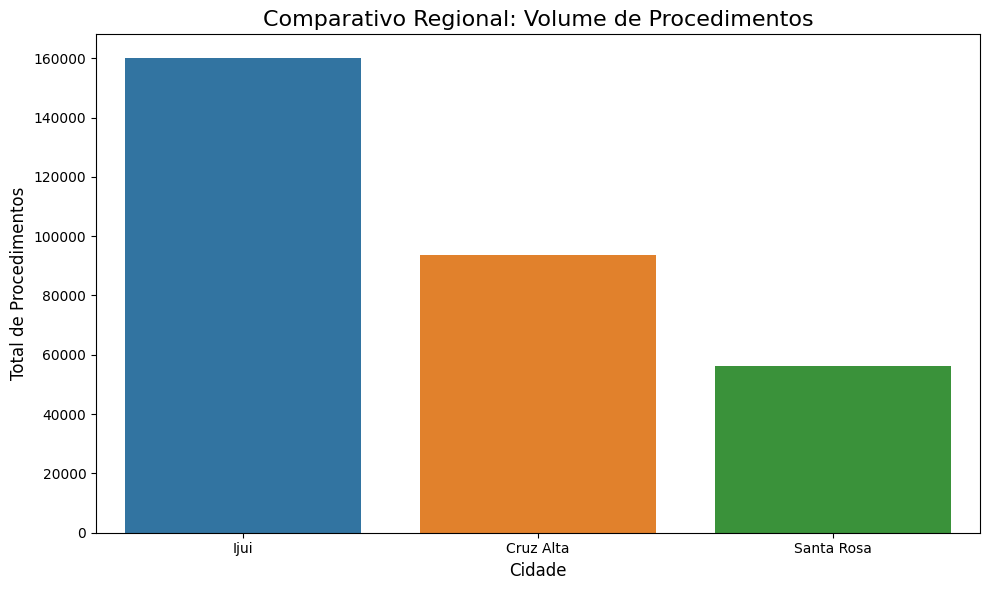

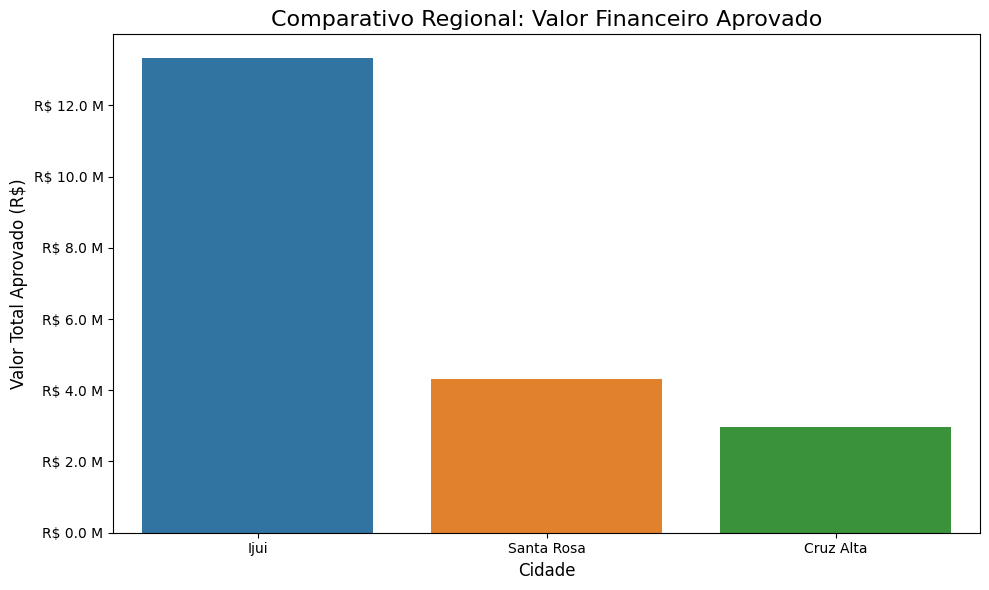

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

try:
    print("--- 📊 Item 7: Iniciando Análise Comparativa Regional ---")
    
    # --- Etapa 1: Definir os códigos das cidades-alvo ---
    # Precisamos dos códigos como NÚMEROS (int),
    # pois a coluna PA_UFMUN é int64
    
    # (O código de Ijuí já está na memória como 'codigo_ijui_int',
    # mas vamos redefini-lo aqui para garantir)
    
    codigos_cidades = {
        'Ijui': 431020,
        'Santa Rosa': 431720,
        'Cruz Alta': 430610
    }
    
    # Lista de códigos como números para o filtro
    lista_codigos_int = list(codigos_cidades.values())
    
    # --- Etapa 2: Ler os arquivos grandes em "Pedaços" (Chunks) ---
    
    arquivos_producao = [
        base_path + 'PARS2501.csv',
        base_path + 'PARS2505.csv',
        base_path + 'PARS2508.csv'
    ]
    
    lista_chunks_regional = []
    
    print("Iniciando leitura otimizada (foco em Ijuí, Sta. Rosa, Cruz Alta)...")
    
    for arquivo in arquivos_producao:
        print(f"Processando arquivo: {arquivo}")
        
        with pd.read_csv(arquivo, encoding='latin1', low_memory=False, chunksize=500000) as reader:
            for chunk in reader:
                # Filtra o pedaço (chunk) para pegar APENAS as linhas
                # das 3 cidades que nos interessam
                chunk_filtrado_regional = chunk[chunk['PA_UFMUN'].isin(lista_codigos_int)]
                
                if not chunk_filtrado_regional.empty:
                    lista_chunks_regional.append(chunk_filtrado_regional)

    print("Leitura em chunks concluída!")
    
    # --- Etapa 3: Juntar os "Pedaços" das 3 cidades ---
    df_regional = pd.concat(lista_chunks_regional, ignore_index=True)
    
    print(f"Tabela regional criada com {len(df_regional)} registros.")
    
    # --- Etapa 4: Análise Comparativa ---
    
    # Mapear os códigos de volta para os nomes das cidades
    # (Criamos um dicionário invertido)
    mapa_nomes_cidades = {v: k for k, v in codigos_cidades.items()}
    df_regional['NOME_CIDADE'] = df_regional['PA_UFMUN'].map(mapa_nomes_cidades)
    
    # Agrupar por cidade e calcular as métricas
    df_comparativo = df_regional.groupby('NOME_CIDADE').agg(
        TOTAL_PROCEDIMENTOS=('PA_UFMUN', 'size'),
        TOTAL_VALOR_APROVADO=('PA_VALAPR', 'sum')
    ).reset_index()

    print("\n--- 📊 Resultado Comparativo (Volume e Valor) ---")
    print(df_comparativo)
    
    # --- Etapa 5: Gerar Gráfico Comparativo (Volume) com Seaborn ---
    print("\nGerando gráfico comparativo (Volume)...")
    
    plt.figure(figsize=(10, 6))
    ax_vol = sns.barplot(
        data=df_comparativo.sort_values('TOTAL_PROCEDIMENTOS', ascending=False),
        x='NOME_CIDADE',
        y='TOTAL_PROCEDIMENTOS'
    )
    plt.title('Comparativo Regional: Volume de Procedimentos', fontsize=16)
    plt.xlabel('Cidade', fontsize=12)
    plt.ylabel('Total de Procedimentos', fontsize=12)
    plt.tight_layout()
    plt.savefig('comparativo_regional_volume.png')
    print("Gráfico 'comparativo_regional_volume.png' salvo.")
    
    # --- Etapa 6: Gerar Gráfico Comparativo (Financeiro) com Seaborn ---
    print("\nGerando gráfico comparativo (Financeiro)...")

    # Função para formatar o eixo Y em Reais (R$ Milhões)
    def format_reais(x, pos):
        return f'R$ {x/1e6:.1f} M'

    plt.figure(figsize=(10, 6))
    ax_fin = sns.barplot(
        data=df_comparativo.sort_values('TOTAL_VALOR_APROVADO', ascending=False),
        x='NOME_CIDADE',
        y='TOTAL_VALOR_APROVADO'
    )
    ax_fin.yaxis.set_major_formatter(FuncFormatter(format_reais))
    plt.title('Comparativo Regional: Valor Financeiro Aprovado', fontsize=16)
    plt.xlabel('Cidade', fontsize=12)
    plt.ylabel('Valor Total Aprovado (R$)', fontsize=12)
    plt.tight_layout()
    plt.savefig('comparativo_regional_financeiro.png')
    print("Gráfico 'comparativo_regional_financeiro.png' salvo.")
    
except NameError as e:
    print(f"Erro: {e}")
    print("\n--- ⚠️ Atenção! ---")
    print("Parece que o estado da memória do notebook foi perdido (kernel reiniciou).")
    print("Por favor, rode novamente a célula que carrega TODOS os 10 arquivos CSV originais (no início do notebook) e tente este código novamente.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Na etapa final da análise, comparamos Ijuí com os outros dois grandes polos regionais: *Santa Rosa e Cruz Alta*. Para fazer isso sem sobrecarregar a memória, utilizamos a metodologia de chunksize (leitura em pedaços), filtrando os *13,2 milhões* de registros totais para extrair apenas os procedimentos realizados nos estabelecimentos desses três municípios. Em seguida, agrupamos os dados para comparar o Volume Total de Procedimentos e o *Valor Total Aprovado (R$)*.

Descobertas e Resultados

- **Volume (Gráfico comparativo_regional_volume.png):**

1. **Ijuí:** 160.060 procedimentos

2. **Cruz Alta:** 93.540 procedimentos

3. *Santa Rosa:* 56.116 procedimentos

- **Financeiro (Gráfico comparativo_regional_financeiro.png):**

1. **Ijuí:** R$ 13,32 milhões

2. **Santa Rosa:** R$ 4,31 milhões

3. **Cruz Alta:** R$ 2,96 milhões

# Conclusão: Informações Estratégicas para a Gestão
Este trabalho transformou **13,2 milhões** de registros de dados brutos do **SIASUS** em informações estratégicas acionáveis para a gestão da saúde em Ijuí.

A análise completa da produção ambulatorial do município (**160.060 procedimentos analisados**) revelou quatro pilares principais que definem o sistema de saúde local:

1. **Ijuí é um Polo Macrorregional**

A rede de saúde de Ijuí não serve apenas aos seus cidadãos. A análise de fluxo (Item 4) revelou que a demanda é quase perfeitamente dividida: *52%* dos pacientes são de Ijuí **(78.559)* e 48%* vêm de outros municípios *(71.062)*, com destaque para *Panambi e Joia*.

**Estratégia:** O planejamento de capacidade e a pactuação financeira com municípios vizinhos são fundamentais para a sustentabilidade do sistema.

2. **O Orçamento é Definido pelo Alto Custo (Não pelo Volume)**

**A análise de Volume vs. Valor (Item 5)** mostrou que os serviços que geram fila (consultas, saúde mental) não são os que geram custo.

**O Custo** é ditado pela alta complexidade, especificamente Oncologia (**R$ 3,82 milhões**) e **Nefrologia/Hemodiálise (R$ 1,16 milhão)**.

**O Volume é ditado pela Atenção Especializada (37 mil consultas) e Saúde Mental (20 mil atendimentos).**

**Estratégia:** A gestão exige duas frentes: uma de eficiência de fluxo (para as consultas/CAPS) e uma de gestão de contratos e custos (para Oncologia/Nefrologia).

3. **O Sistema é Focado no Envelhecimento**

A **"tendência de envelhecimento"** não é um problema futuro; é a realidade atual (Item 6). A idade mediana dos pacientes é de 58 anos.

**83%** de todos os procedimentos de **Cardiologia e Oncologia** são realizados em pacientes com 50 anos ou mais.

**Estratégia:** O planejamento de especialidades e a alocação de recursos do município devem ser primariamente focados no cuidado ao paciente idoso e no tratamento de doenças crônicas.

4. **Alerta Crítico: O Ponto Cego do "CID Não Informado"**

A maior ameaça à gestão estratégica é a qualidade dos dados (Item 3). **60%** de todos os procedimentos (**89.693 registros**) não possuem um diagnóstico (CID) informado.

**Estratégia:** É impossível realizar um planejamento epidemiológico eficaz sem saber quais doenças estão sendo tratadas. É urgente auditar o sistema de registro (principalmente no **HCI e Bom Pastor**) para corrigir essa falha, que atualmente cria o maior ponto cego para a gestão.